1/1 [==============================] - 1s 1s/step
Predicted: [('n02992529', 'cellular_telephone', 0.005984489)]
Shape of last_conv_layer_output: (1, 10, 10, 2048)
Shape of grads: (1, 10, 10, 2048)
Shape of pooled_grads: (2048,)


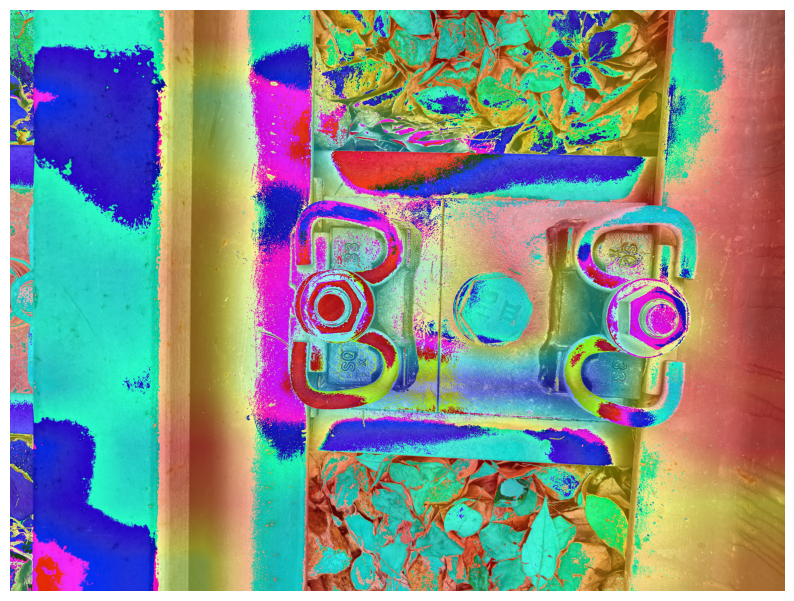

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import cv2
from PIL import ImageFile

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Load the pre-trained ResNet50 model with a custom input shape
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Add a global spatial average pooling layer
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units and ReLU activation
predictions = Dense(1000, activation='softmax')(x)  # Output layer with 1000 units (for ImageNet classes)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Load and preprocess the image
img_path = '/content/IMG20240605140005.jpg'
img = image.load_img(img_path, target_size=(299, 299))  # Resize to match new input shape
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Make predictions
preds = model.predict(img_array)
print('Predicted:', decode_predictions(preds, top=1)[0])

# Get the class index
class_idx = np.argmax(preds[0])
class_output = model.output[:, class_idx]

# Get the last convolutional layer
last_conv_layer = base_model.get_layer('conv5_block3_out')

# Create a model that maps the input image to the activations of the last conv layer
intermediate_model = Model(inputs=base_model.input, outputs=[last_conv_layer.output, model.output])

# Get the feature maps and model predictions
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = intermediate_model(img_array)
    class_output = preds[:, class_idx]

# Get the gradient of the class output with respect to the feature map
grads = tape.gradient(class_output, last_conv_layer_output)

# Debug statement to check the shapes
print(f"Shape of last_conv_layer_output: {last_conv_layer_output.shape}")
print(f"Shape of grads: {grads.shape}")

# Get the gradients for the first (and only) image in the batch
grads = grads[0]

# Compute the guided gradients
pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

# Debug statement to check the shape of pooled_grads
print(f"Shape of pooled_grads: {pooled_grads.shape}")

# Get the feature map for the first (and only) image in the batch
conv_outputs = last_conv_layer_output[0]

# Convert tensors to numpy arrays for modification
conv_outputs = conv_outputs.numpy()
pooled_grads = pooled_grads.numpy()

# Weight each channel by corresponding gradients
for i in range(pooled_grads.shape[0]):
    conv_outputs[:, :, i] *= pooled_grads[i]

# Generate the class activation map
heatmap = np.mean(conv_outputs, axis=-1)

# Normalize the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)

# Resize the heatmap to the size of the original image
heatmap = cv2.resize(heatmap, (299, 299))
heatmap = np.uint8(255 * heatmap)

# Apply the heatmap to the original image
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Load the original image to match its size with the heatmap
original_img = image.load_img(img_path)
original_img = image.img_to_array(original_img)

# Resize the heatmap to match the original image size
heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

# Superimpose the heatmap onto the original image
superimposed_img = heatmap * 0.4 + original_img

# Display the image with the CAM
plt.figure(figsize=(10, 10))
plt.imshow(superimposed_img.astype('uint8'))
plt.axis('off')
plt.show()


In [ ]:
from PIL import Image

# Load the image
img_path = '/content/IMG20240605140011.jpg'
img = Image.open(img_path)

# Get the size of the image
width, height = img.size
print(f"Image size (width x height): {width} x {height}")

Image size (width x height): 4096 x 3072
